# Menhaden Scale Image Preprocessing
The raw menhaden images taken under a microscope need to be preprocessed so that the deep learning model can better focus on the scale of interest with minimal interference from surrounding background noise.

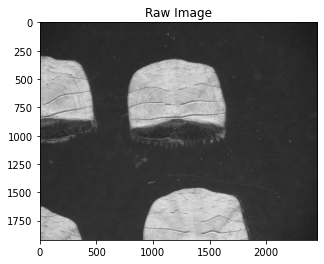

In [31]:
import cv2 as cv
from matplotlib import pyplot as plt
import numpy as np 
raw_image = cv.imread("Raw Image/17763.tif")
img2 = raw_image[:,:,::-1]
plt.imshow(img2)
plt.title('Raw Image')
plt.show()

In the example above, the scale of interest (centered) is also surrounded by three other scales on the left, bottom, and lower left corner.  To properly prepare this data for input into neural network, we need to isolate the center scale and also make the image square through padding while preserving the aspect ratio.

## Binary Thresholding
To process the raw image, we first need to transform the image into a grayscale and perform binary thresholding.  The current threshold value is 100 out of 255.  I found this value to work well for menhaden images.  This can be adjusted depending on future images taken.

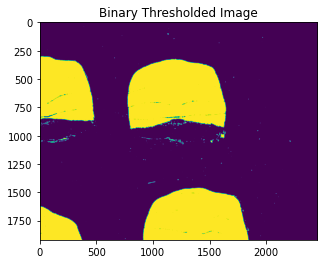

In [32]:
threshold_value = 100
gray_image = cv.cvtColor(raw_image, cv.COLOR_BGR2GRAY)
ret, thresh = cv.threshold(gray_image,threshold_value,255,cv.THRESH_BINARY)
plt.imshow(thresh)
plt.title('Binary Thresholded Image')
plt.show()

## Morphological Operation
After initial thresholding, we can largely makeout the shape of the scales in the binary mask, but the masks are still incomplete.  There are small missing portions inside the mask (yellow) and there are also small pieces of mask floating in space.  These imperfections can be fixed through morphological opening and closing. If these imperfections still persist, you can try increasing the kernel size. 

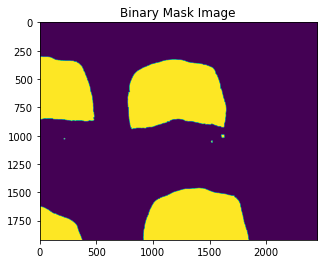

In [33]:
kernel = np.ones((10,10),np.uint8)
opening = cv.morphologyEx(thresh, cv.MORPH_OPEN, kernel)
closing = cv.morphologyEx(opening, cv.MORPH_CLOSE, kernel)
plt.imshow(closing)
plt.title('Binary Mask Image')
plt.show()

## Find Contours
Now that we have largely complete masks of the scales, we can use the find contours function to identify each separate object in the binary image.  We assume the largest contour to be the object of interest as all other scales are (presumably) only partially in frame.

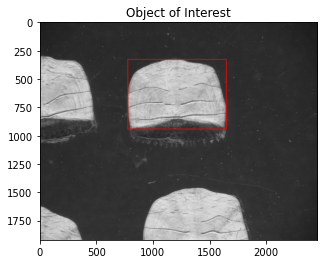

In [34]:
contours, hierarchy = cv.findContours(closing, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)
if(len(contours) > 0):
    maxidx = 0
    maxarea = 0
    for i in range(len(contours)):
        contour = contours[i]
        if cv.contourArea(contour) > maxarea:
            maxarea = cv.contourArea(contour)
            maxidx = i
    x,y,w,h = cv.boundingRect(contours[maxidx])
start = (x,y)
end = (x+w, y+h)
color = (255, 0, 0)
thickness = 5
display = raw_image.copy()
display = cv.rectangle(display, start, end, color, thickness)
plt.imshow(display)
plt.title('Object of Interest')
plt.show()

We extend the bounding box by some margin to include all of the scale, especially the bottom

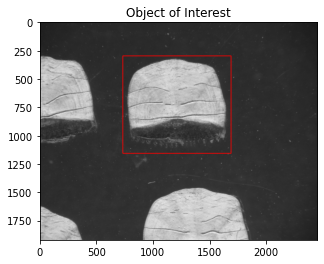

In [37]:
xmargin = 0.05
ymargin_top = 0.05
ymargin_bot = 0.35
y_max, x_max,c = raw_image.shape
x_new = int(max(0,x-w*xmargin))
y_new = int(max(0,y-h*ymargin_top))
w_new = int(min(w*(1+xmargin*2),x_max-x_new))
h_new = int(min(h*(1+ymargin_top+ymargin_bot), y_max-y_new))

start = (x_new,y_new)
end = (x_new+w_new, y_new+h_new)
color = (255, 0, 0)
thickness = 5
display = raw_image.copy()
display = cv.rectangle(display, start, end, color, thickness)
plt.imshow(display)
plt.title('Object of Interest')
plt.show()

## Crop and Pad
After getting the bounding rectangle for the scale, we first crop the scale, then pad with the boundary pixels until the image is square.

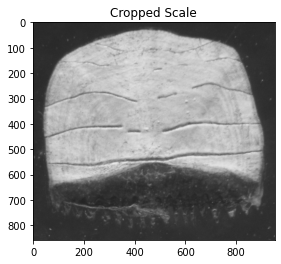

In [41]:
crop = raw_image[y_new:y_new+h_new,x_new:x_new+w_new,:]
plt.imshow(crop)
plt.title('Cropped Scale')
plt.show()

(952, 953, 3)


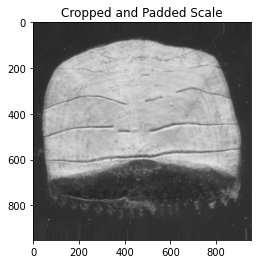

In [45]:
c_h, c_w, c = crop.shape
left, right, top, bottom = 0,0,0,0
if(c_h>c_w):
    difference = c_h-c_w
    left = int(difference/2)
    right = int(difference/2)
if(c_h<c_w):
    difference = c_w-c_h
    top = int(difference/2)
    bottom = int(difference/2)
crop_pad = cv.copyMakeBorder(crop, top, bottom, left, right, cv.BORDER_REPLICATE)
plt.imshow(crop_pad)
plt.title('Cropped and Padded Scale')
plt.show()

## Process Folder of Images
Here we will put everything together into a function that can process a folder of images and output the cropped and padded images into another folder

In [53]:
import os

def crop_and_pad(image, kernel_size = 10, threshold=100, pad=0.05, bottom_pad = 0.35):
    #Binary threshold
    gray_image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    ret, thresh = cv.threshold(gray_image,threshold,255,cv.THRESH_BINARY)
    kernel = np.ones((kernel_size,kernel_size),np.uint8)
    
    #Morphological operation
    opening = cv.morphologyEx(thresh, cv.MORPH_OPEN, kernel)
    closing = cv.morphologyEx(opening, cv.MORPH_CLOSE, kernel)
    
    #Find Contours
    contours, hierarchy = cv.findContours(closing, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)
    if(len(contours) > 0):
        maxidx = 0
        maxarea = 0
        for i in range(len(contours)):
            contour = contours[i]
            if cv.contourArea(contour) > maxarea:
                maxarea = cv.contourArea(contour)
                maxidx = i
        x,y,w,h = cv.boundingRect(contours[maxidx])
        
    #Crop and Pad
    xmargin = pad
    ymargin_top = pad
    ymargin_bot = bottom_pad
    y_max, x_max,c = raw_image.shape
    x_new = int(max(0,x-w*xmargin))
    y_new = int(max(0,y-h*ymargin_top))
    w_new = int(min(w*(1+xmargin*2),x_max-x_new))
    h_new = int(min(h*(1+ymargin_top+ymargin_bot), y_max-y_new))
    crop = image[y_new:y_new+h_new,x_new:x_new+w_new,:]
    
    c_h, c_w, c = crop.shape
    left, right, top, bottom = 0,0,0,0
    if(c_h>c_w):
        difference = c_h-c_w
        left = int(difference/2)
        right = int(difference/2)
    if(c_h<c_w):
        difference = c_w-c_h
        top = int(difference/2)
        bottom = int(difference/2)
    crop_pad = cv.copyMakeBorder(crop, top, bottom, left, right, cv.BORDER_REPLICATE)

    return crop

def preprocess_folder(image_dir, output_dir, extension = ".tif", kernel_size = 10, threshold=100, pad=0.05, bottom_pad = 0.35):
    if(not os.path.exists(output_dir)):
        os.mkdir(output_dir)
    for file in os.listdir(image_dir):
        if file.endswith(extension):
            image = cv.imread(image_dir+"/"+file)
            cropped_image = crop_and_pad(image, kernel_size, threshold, pad, bottom_pad)
            cv.imwrite(output_dir+"/"+os.path.splitext(file)[0]+".jpg",cropped_image)
preprocess_folder("Raw Image", "cropped")